In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM,BatchNormalization
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
DataPath=  '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/RML2016.10b.dat' #'/content/drive/MyDrive/ModulationClassification/RML2016.10b.dat'

In [ ]:
pickle_in = open(DataPath,"rb")
data = pickle.load(pickle_in, encoding="bytes")

In [ ]:
def load_data(data):
  s = np.empty((0,128,2))
  l=np.array([])
  for key in data.keys():
    # load samples
    x,y=key
    x = x.decode('ascii')
    samples = np.array(data.get(key)).transpose(0, 2, 1)
    # create labels
    labels = np.repeat(x+'_'+str(y),samples.shape[0])
    l=np.concatenate([l,labels])
    s=np.vstack((s,samples))
    print('key',key)
    print("samples:",samples.shape)
    print('labels',labels.shape)
  return l,s,data.keys()
  

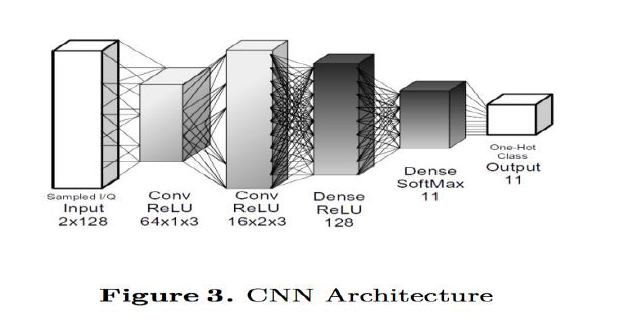

In [ ]:
def first_drev(data):
  drev = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = np.gradient(data[i*6000:i*6000+6000][:][:],axis=1)
    drev=np.vstack((drev,tmp))
    del tmp
  return drev


In [ ]:
def integral(data):
  data=np.pad(data, [(0, 0),(0,0),(0,1)], 'constant')
  integral = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = scipy.integrate.cumtrapz(data[i*6000:i*6000+6000][:][:],dx=1)
    integral=np.vstack((integral,tmp))
    del tmp
  return integral

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def create_model():
  number_of_channels = 4 
  model = Sequential()
  
  model.add(LSTM(64, input_shape=(128,number_of_channels)))

  model.add(BatchNormalization())

  model.add(Dense(10, activation ='softmax'))

  
  return model

In [ ]:
# get samples and labels
labels, samples,classes = load_data(data)

key (b'QPSK', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'AM-DSB', -4)
samples: (6000, 128, 2)
labels (6000,)
key (b'GFSK', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 18)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', -20)
samples: (6000, 128, 2)
labels (6000,)
key (b'8PSK', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'CPFSK', 10)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 4)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', -2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QPSK', -20)
samples: (

In [ ]:
samples = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/drev_raw.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/labels.npy')
#classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')
gc.collect()

27

In [ ]:
# test drevative
d = np.array(first_drev(samples))
print("drevative:",d.shape)



In [ ]:
# test integration
i = np.array(integral(samples))
print("integral:",i.shape)

In [ ]:
# to encode the labels
lb = LabelEncoder()
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)
del samples
del labels
gc.collect()
# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
del y_train
del y_val
gc.collect()

0

Learning rate: 1e-05
Epoch 1/100
24938/24938 [==============================] - 194s 7ms/step - loss: 2.1678 - accuracy: 0.1481 - val_loss: 2.1405 - val_accuracy: 0.1586
Epoch 2/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1291 - accuracy: 0.1656 - val_loss: 2.1216 - val_accuracy: 0.1596
Epoch 3/100
24938/24938 [==============================] - 182s 7ms/step - loss: 2.1207 - accuracy: 0.1683 - val_loss: 2.1239 - val_accuracy: 0.1694
Epoch 4/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1175 - accuracy: 0.1686 - val_loss: 2.1116 - val_accuracy: 0.1741
Epoch 5/100
24938/24938 [==============================] - 178s 7ms/step - loss: 2.1157 - accuracy: 0.1693 - val_loss: 2.1166 - val_accuracy: 0.1685
Epoch 6/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1148 - accuracy: 0.1698 - val_loss: 2.1262 - val_accuracy: 0.1727
Epoch 7/100
24938/24938 [==============================] - 180s 7ms/step - loss: 2.11

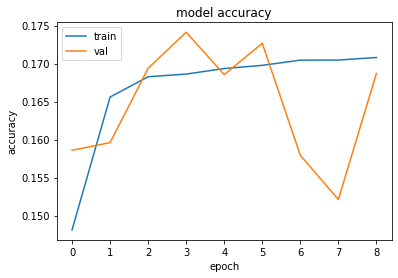

**************************************************


Learning rate: 1e-06
Epoch 1/100
24938/24938 [==============================] - 186s 7ms/step - loss: 2.2790 - accuracy: 0.1335 - val_loss: 2.1926 - val_accuracy: 0.1378
Epoch 2/100
24938/24938 [==============================] - 186s 7ms/step - loss: 2.1740 - accuracy: 0.1478 - val_loss: 2.1667 - val_accuracy: 0.1521
Epoch 3/100
24938/24938 [==============================] - 182s 7ms/step - loss: 2.1672 - accuracy: 0.1500 - val_loss: 2.1724 - val_accuracy: 0.1584
Epoch 4/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1645 - accuracy: 0.1520 - val_loss: 2.1636 - val_accuracy: 0.1535
Epoch 5/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1625 - accuracy: 0.1533 - val_loss: 2.1641 - val_accuracy: 0.1535
Epoch 6/100
24938/24938 [==============================] - 181s 7ms/step - loss: 2.1612 - accuracy: 0.1532 - val_loss: 2.1641 - val_accuracy: 0.1545
Epoch 7/100
24938/24938 [=======

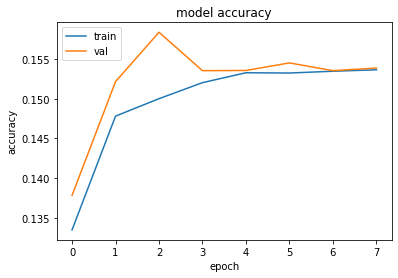

**************************************************




In [ ]:
#1e-1,1e-2,1e-3,
rates = [1e-5,1e-6]
epochs = 100
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/lstm/'
checkpoint_filepath = path+'checkpoint_dervative_lstm'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
for lr in rates:
  print("Learning rate:",lr)
  model = create_model()
  callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
  opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

  # train model
  cnn_results = model.fit(x_train, y_train_lb,
                  epochs = epochs,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=[callback,model_checkpoint_callback])
  # Plot model accuracy over ephocs
  plt.plot(cnn_results.history['accuracy'])
  plt.plot(cnn_results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(path+'dervative_lstm'+f'lr_{str(lr)}.png')
  plt.show()
  print("**************************************************\n\n")
  del model
  gc.collect()

Epoch 1/30
12469/12469 [==============================] - 105s 8ms/step - loss: 2.1313 - accuracy: 0.1619 - val_loss: 2.1028 - val_accuracy: 0.1687
Epoch 2/30
12469/12469 [==============================] - 100s 8ms/step - loss: 2.0927 - accuracy: 0.1799 - val_loss: 2.0726 - val_accuracy: 0.1847
Epoch 3/30
12469/12469 [==============================] - 98s 8ms/step - loss: 1.9694 - accuracy: 0.2213 - val_loss: 1.8131 - val_accuracy: 0.2771
Epoch 4/30
12469/12469 [==============================] - 98s 8ms/step - loss: 1.7373 - accuracy: 0.3054 - val_loss: 1.7032 - val_accuracy: 0.3141
Epoch 5/30
12469/12469 [==============================] - 97s 8ms/step - loss: 1.6807 - accuracy: 0.3268 - val_loss: 1.6649 - val_accuracy: 0.3305
Epoch 6/30
12469/12469 [==============================] - 98s 8ms/step - loss: 1.6500 - accuracy: 0.3385 - val_loss: 1.6427 - val_accuracy: 0.3411
Epoch 7/30
12469/12469 [==============================] - 102s 8ms/step - loss: 1.6259 - accuracy: 0.3476 - val_loss

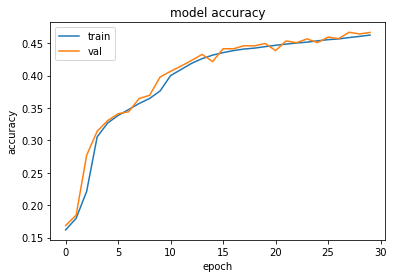

In [ ]:
# training
model = create_model()
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/backup/lstm/'
checkpoint_filepath = path+'checkpoint_dervative_lstm'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 30,
                  batch_size= 64,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=[model_checkpoint_callback])
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/backup/lstm_drev.h5')

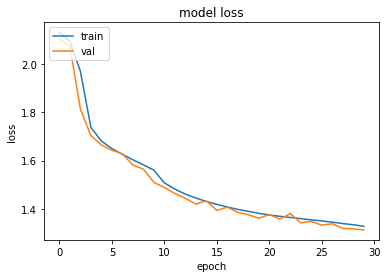

In [ ]:
# Plot model loss over ephocs
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# train accuracy
score = model.evaluate(x_train, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.09997870028018951


In [ ]:
del x_train
del y_train_lb
gc.collect()

10459

In [ ]:
# evaluate test set
# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.4661666750907898


In [ ]:
# to get confusion matrix
y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)


In [ ]:
classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')

In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',13759,986,5343,2320,4917,263,3506,2797,1785,324
b'AM-DSB',484,25514,2670,456,3451,5,5,7,495,2913
b'BPSK',2280,985,22276,1812,4499,848,201,215,2569,315
b'CPFSK',1827,1042,4373,21438,5532,63,224,276,849,376
b'GFSK',806,1627,3546,981,27200,13,37,51,500,1239
b'PAM4',2903,739,4512,1663,3548,18457,941,2058,941,238
b'QAM16',6738,619,3456,1566,3133,1294,4360,13571,1018,245
b'QAM64',5818,418,2477,1367,2178,1609,4214,16863,866,190
b'QPSK',6540,988,5412,2686,4808,260,2468,2643,9874,321
b'WBFM',596,18788,2721,525,4799,9,9,5,469,8079


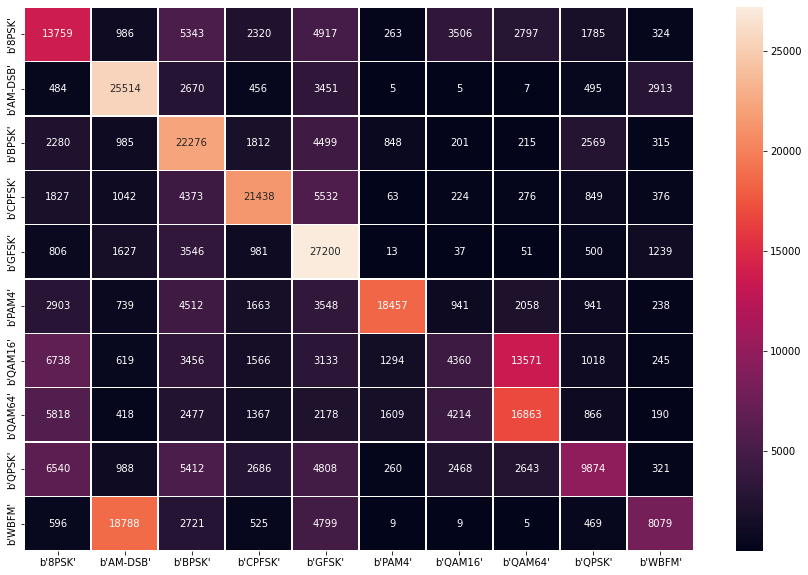

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.4852865535235294
Recall:  0.46616666666666673
F-score:  0.44914614283763854


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.38,10.7,11.67,12.83,16.2,22.31,28.43,36.58,45.46,54.61,62.36,66.56,67.71,69.15,69.31,69.81,69.06,69.83,69.65,69.75


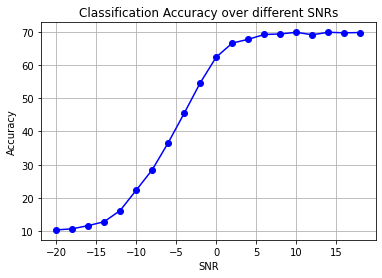

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)